In [96]:
import pandas as pd
import numpy as np

In [150]:
spy = pd.read_excel('../data/pricing_data.xlsx', sheet_name='SPY')

# Convert the 'Date' column to datetime format
spy['Date'] = pd.to_datetime(spy['Date'])

# Sort by date
spy = spy.sort_values(by='Date')

# Reset index if needed
spy.reset_index(drop=True, inplace=True)

In [98]:
'''
# Calculate lagged prices
spy['PrevHigh'] = spy['High'].shift(1)
spy['PrevLow'] = spy['Low'].shift(1)
spy['PrevClose'] = spy['Close'].shift(1)

# Calculate true range component
spy['TR1'] = spy['High'] - spy['Low']
spy['TR2'] = abs(spy['High'] - spy['PrevClose'])
spy['TR3'] = abs(spy['Low'] - spy['PrevClose'])

# Calculate true range as the max of the three TRs
spy['TR'] = spy[['TR1', 'TR2', 'TR3']].max(axis=1)
spy.at[spy.index[0], 'TR'] = np.nan

# Initialize +DM and -DM columns
spy['+DM'] = 0.0
spy['-DM'] = 0.0

# Calculate +DM and -DM
for i in range(1, len(spy)):
    high_diff = spy['High'].iloc[i] - spy['PrevHigh'].iloc[i]
    low_diff = spy['PrevLow'].iloc[i] - spy['Low'].iloc[i]
    
    if high_diff >= low_diff and high_diff > 0:
        spy.at[spy.index[i], '+DM'] = high_diff
    if low_diff >= high_diff and low_diff > 0:
        spy.at[spy.index[i], '-DM'] = low_diff

# Smooth TR, +DM, and -DM using EMA
period = 10
spy['TR_smooth'] = spy['TR'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:9], 'TR_smooth'] = np.nan  # Set first 9 TR_smooth to NaN

spy['+DM_smooth'] = spy['+DM'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:9], '+DM_smooth'] = np.nan
spy['-DM_smooth'] = spy['-DM'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:9], '-DM_smooth'] = np.nan

# Calculate +DI and -DI
spy['+DI'] = (spy['+DM_smooth'] / spy['TR_smooth']) * 100
spy['-DI'] = (spy['-DM_smooth'] / spy['TR_smooth']) * 100

# Calculate DX and ADX
spy['DX'] = (abs(spy['+DI'] - spy['-DI']) / (spy['+DI'] + spy['-DI'])) * 100
spy['ADX'] = spy['DX'].ewm(span=period, adjust=False).mean()
spy.loc[spy.index[:20], 'ADX'] = np.nan # first few ADXs are not stable due to NAs
'''

"\n# Calculate lagged prices\nspy['PrevHigh'] = spy['High'].shift(1)\nspy['PrevLow'] = spy['Low'].shift(1)\nspy['PrevClose'] = spy['Close'].shift(1)\n\n# Calculate true range component\nspy['TR1'] = spy['High'] - spy['Low']\nspy['TR2'] = abs(spy['High'] - spy['PrevClose'])\nspy['TR3'] = abs(spy['Low'] - spy['PrevClose'])\n\n# Calculate true range as the max of the three TRs\nspy['TR'] = spy[['TR1', 'TR2', 'TR3']].max(axis=1)\nspy.at[spy.index[0], 'TR'] = np.nan\n\n# Initialize +DM and -DM columns\nspy['+DM'] = 0.0\nspy['-DM'] = 0.0\n\n# Calculate +DM and -DM\nfor i in range(1, len(spy)):\n    high_diff = spy['High'].iloc[i] - spy['PrevHigh'].iloc[i]\n    low_diff = spy['PrevLow'].iloc[i] - spy['Low'].iloc[i]\n    \n    if high_diff >= low_diff and high_diff > 0:\n        spy.at[spy.index[i], '+DM'] = high_diff\n    if low_diff >= high_diff and low_diff > 0:\n        spy.at[spy.index[i], '-DM'] = low_diff\n\n# Smooth TR, +DM, and -DM using EMA\nperiod = 10\nspy['TR_smooth'] = spy['TR'].

In [151]:
# Calculate price changes
spy['PriceChange'] = spy['Close'].diff()

# Calculate percentage changes
spy['PctChange'] = spy['Close'].pct_change()

# Cap percentage changes at ±3%
spy['CappedPctChange'] = spy['PctChange'].clip(lower=-0.03, upper=0.03)

# Calculate capped price changes
spy['CappedPriceChange'] = spy['CappedPctChange'] * spy['Close'].shift(1)

# Separate gains and losses
spy['Gain'] = spy['CappedPriceChange'].where(spy['CappedPriceChange'] > 0, 0)
spy['Loss'] = -spy['CappedPriceChange'].where(spy['CappedPriceChange'] < 0, 0)

# Calculate average gains and losses (using a 26-period window)
window = 13
spy['AvgGain'] = spy['Gain'].rolling(window=window, min_periods=1).mean()
spy['AvgLoss'] = spy['Loss'].rolling(window=window, min_periods=1).mean()

# Calculate the relative strength
spy['RS'] = spy['AvgGain'] / spy['AvgLoss']

# Calculate RSI
spy['RSI'] = 100 - (100 / (1 + spy['RS']))

# Set first few RSI values to NaN due to instability
spy.loc[spy.index[:window-1], 'RSI'] = np.nan


In [152]:
spy['MA200'] = spy['Close'].rolling(window=200).mean()
spy['MA20'] = spy['Close'].rolling(window=20).mean()
spy['MA50'] = spy['Close'].rolling(window=50).mean()

In [153]:

k_period = 12
d_period = 3
spy['HighestHigh'] = spy['High'].rolling(window=k_period).max()
spy['LowestLow'] = spy['Low'].rolling(window=k_period).min()

# Calculate %K
spy['%K'] = 100 * (spy['Close'] - spy['LowestLow']) / (spy['HighestHigh'] - spy['LowestLow'])

# Calculate %D (the moving average of %K)
spy['%D'] = spy['%K'].rolling(window=d_period).mean()

In [154]:

spy['EMA_6'] = spy['Close'].rolling(window=12).mean() # 6-period EMA
spy['EMA_12'] = spy['Close'].rolling(window=26).mean() # 12-period EMA

# Calculate the MACD line
spy['MACD'] = spy['EMA_6'] - spy['EMA_12']

spy['Signal'] = spy['MACD'].ewm(span=9, adjust=False).mean()

In [155]:
def calculate_mfi(df, period=14):
    # Ensure the dataframe has the required columns
    required_columns = ['High', 'Low', 'Close', 'Volume']
    if not all(col in df.columns for col in required_columns):
        raise ValueError("Dataframe must have 'High', 'Low', 'Close', and 'Volume' columns")

    # Calculate Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3

    # Calculate Raw Money Flow
    df['Raw_Money_Flow'] = df['TP'] * df['Volume']

    # Calculate Money Flow Direction
    df['Money_Flow_Direction'] = np.where(df['TP'] > df['TP'].shift(1), 1, -1)

    # Calculate Positive and Negative Money Flows
    df['Positive_Money_Flow'] = np.where(df['Money_Flow_Direction'] > 0, df['Raw_Money_Flow'], 0)
    df['Negative_Money_Flow'] = np.where(df['Money_Flow_Direction'] < 0, df['Raw_Money_Flow'], 0)

    # Calculate Money Flow Ratio
    positive_money_flow_sum = df['Positive_Money_Flow'].rolling(window=period).sum()
    negative_money_flow_sum = df['Negative_Money_Flow'].rolling(window=period).sum()
    money_flow_ratio = positive_money_flow_sum / negative_money_flow_sum

    # Calculate Money Flow Index
    mfi = 100 - (100 / (1 + money_flow_ratio))

    return mfi

# Example usage:
# Assuming you have a DataFrame 'df' with 'High', 'Low', 'Close', and 'Volume' columns
spy['MFI'] = calculate_mfi(spy)


In [104]:
'''
spy['PrevHigh2'] = spy['High'].shift(2)
spy['BreakHigh2'] = (spy['High'] > spy['PrevHigh']) & (spy['PrevHigh'] > spy['PrevHigh2'])

spy['PrevLow2'] = spy['Low'].shift(2)
spy['BreakLow2'] = (spy['Low'] < spy['PrevLow']) & (spy['PrevLow'] < spy['PrevLow2'])
'''

"\nspy['PrevHigh2'] = spy['High'].shift(2)\nspy['BreakHigh2'] = (spy['High'] > spy['PrevHigh']) & (spy['PrevHigh'] > spy['PrevHigh2'])\n\nspy['PrevLow2'] = spy['Low'].shift(2)\nspy['BreakLow2'] = (spy['Low'] < spy['PrevLow']) & (spy['PrevLow'] < spy['PrevLow2'])\n"

In [105]:
'''
spy['TROpen'] = spy['Open'].diff()
spy['TRHigh'] = spy['High'].diff()
spy['TRLow'] = spy['Low'].diff()
spy['TRClose'] = spy['Close'].diff()
spy['TRShort_SMA'] = spy['SMAVG (5)  on Close'].diff()
spy['TRLong_SMA'] = spy['SMAVG (10)  on Close'].diff()

# Calculate exponential moving averages
spy['Short_EMA'] = spy['Close'].ewm(span=5, adjust=False).mean()
spy['Long_EMA'] = spy['Close'].ewm(span=10, adjust=False).mean()
spy['TRShort_EMA'] = spy['Short_EMA'].diff()
spy['TRLong_EMA'] = spy['Long_EMA'].diff()

spy['DayOfWeek'] = spy['Date'].dt.dayofweek
'''

"\nspy['TROpen'] = spy['Open'].diff()\nspy['TRHigh'] = spy['High'].diff()\nspy['TRLow'] = spy['Low'].diff()\nspy['TRClose'] = spy['Close'].diff()\nspy['TRShort_SMA'] = spy['SMAVG (5)  on Close'].diff()\nspy['TRLong_SMA'] = spy['SMAVG (10)  on Close'].diff()\n\n# Calculate exponential moving averages\nspy['Short_EMA'] = spy['Close'].ewm(span=5, adjust=False).mean()\nspy['Long_EMA'] = spy['Close'].ewm(span=10, adjust=False).mean()\nspy['TRShort_EMA'] = spy['Short_EMA'].diff()\nspy['TRLong_EMA'] = spy['Long_EMA'].diff()\n\nspy['DayOfWeek'] = spy['Date'].dt.dayofweek\n"

In [ ]:
'''
# Calculate Bollinger Bands for volaility measure
# Calculate the standard deviation
spy['STD15'] = spy['Close'].rolling(window=30).std()

# Calculate Bollinger Bands
spy['BB_Upper'] = spy['SMAVG (15)  on Close'] + (spy['STD15'] * 2)
spy['BB_Lower'] = spy['SMAVG (15)  on Close'] - (spy['STD15'] * 2)

# Calculate Bollinger Band Width
spy['BB_Width'] = (spy['BB_Upper'] - spy['BB_Lower']) / spy['SMAVG (15)  on Close']

# Calculate the Percent B
# spy['Percent_B'] = (spy['Close'] - spy['BB_Lower']) / (spy['BB_Upper'] - spy['BB_Lower'])

# Calculate Bollinger Band Squeeze
# spy['BB_Squeeze'] = spy['BB_Width'].rolling(window=15).mean()'
'''

In [156]:
# Calculate Bollinger Bands for volaility measure
# Calculate the standard deviation
spy['STD15'] = spy['Close'].rolling(window=30).std()

# Calculate Bollinger Bands
spy['BB_Upper'] = spy['MA20'] + (spy['STD15'] * 2)
spy['BB_Lower'] = spy['MA20'] - (spy['STD15'] * 2)

# Calculate Bollinger Band Width
spy['BB_Width'] = (spy['BB_Upper'] - spy['BB_Lower']) / spy['SMAVG (15)  on Close']

# Calculate the Percent B
# spy['Percent_B'] = (spy['Close'] - spy['BB_Lower']) / (spy['BB_Upper'] - spy['BB_Lower'])

# Calculate Bollinger Band Squeeze
# spy['BB_Squeeze'] = spy['BB_Width'].rolling(window=15).mean()

In [157]:
# Create lagged columns (shift by 1)
lagged_spy = spy.copy()
for col in spy.columns:
    if col not in ['Date', 'Close']:  # Skip Date and Close
        lagged_spy[col + '_lag1'] = spy[col].shift(1)

# Keep only Date, Close, and the lagged columns
lagged_spy = lagged_spy[['Date', 'Close', 'Open'] + [col + '_lag1' for col in spy.columns if col not in ['Date', 'Close']]]

lagged_spy.drop(index=lagged_spy.index[:30], inplace=True)

# Display result
lagged_spy.head()

,Date,Close,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,SMAVG (15) on Close_lag1,Volume_lag1,...,TP_lag1,Raw_Money_Flow_lag1,Money_Flow_Direction_lag1,Positive_Money_Flow_lag1,Negative_Money_Flow_lag1,MFI_lag1,STD15_lag1,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1
30,2024-01-05 00:30:00,469.720,470.670,469.910,470.960,469.890,469.601,469.894,469.815,2917109.0,...,470.505667,1.372516e+09,1.0,1.372516e+09,0.000000e+00,48.031898,1.343277,472.736454,467.363346,0.011437
31,2024-01-05 01:00:00,469.610,469.710,470.670,470.820,469.460,469.787,469.831,469.836,3120550.0,...,470.000000,1.466658e+09,-1.0,0.000000e+00,1.466658e+09,41.895293,1.333143,472.655686,467.323114,0.011350
32,2024-01-05 01:30:00,469.115,469.619,469.710,469.838,469.260,469.933,469.784,469.829,2310121.0,...,469.569333,1.084762e+09,-1.0,0.000000e+00,1.084762e+09,42.132086,1.333647,472.592194,467.257606,0.011354
33,2024-01-05 02:00:00,469.330,469.110,469.619,469.620,468.665,469.802,469.594,469.818,2536075.0,...,469.133333,1.189757e+09,-1.0,0.000000e+00,1.189757e+09,42.071924,1.348026,472.444202,467.052098,0.011477
34,2024-01-05 02:30:00,469.100,469.330,469.110,469.410,468.970,469.688,469.505,469.802,1662092.0,...,469.236667,7.799145e+08,1.0,7.799145e+08,0.000000e+00,40.949644,1.325959,472.376068,467.072232,0.011290


In [158]:
lagged_spy = lagged_spy[(lagged_spy['Date'] >= '2025-01-01') & (lagged_spy['Date'] < '2025-03-01')]

In [1063]:
import pandas as pd
import numpy as np

# Reset index for safety
lagged_spy = lagged_spy.reset_index(drop=True)

# Initialize trading signals and portfolio
lagged_spy['Position'] = 0  # 1 for long, -1 for short, 0 for cash
lagged_spy['Returns'] = lagged_spy['Close'].pct_change()

# Initialize portfolio values
initial_cash = 10000
cash = initial_cash
spy_shares = 0
short_position = 0
commission_rate = 0.0005  # 0.05% commission per trade

lagged_spy['Strategy_Portfolio'] = initial_cash
lagged_spy['BuyHold_Portfolio'] = initial_cash

for i in range(1, len(lagged_spy)):
    current_open = lagged_spy.at[i, 'Open']
    prev_close = lagged_spy.at[i-1, 'Close']
    prev_ma200 = lagged_spy.at[i, 'MA200_lag1']
    prev_ma20 = lagged_spy.at[i, 'MA20_lag1']
    prev_ma50 = lagged_spy.at[i, 'MA50_lag1']
    prev_rsi = lagged_spy.at[i, 'RSI_lag1']
    lowerbb = lagged_spy.at[i, 'BB_Lower_lag1']
    upperbb = lagged_spy.at[i, 'BB_Upper_lag1']
    prev_mfi = lagged_spy.at[i, 'MFI_lag1']
    
    # Trading logic
    if (prev_mfi >= 80) and (prev_ma20 <= prev_ma50):
        # Short signal
        lagged_spy.at[i, 'Position'] = -1
    elif (prev_mfi <= 20) and (prev_ma20 >= prev_ma50):
        # Long signal
        lagged_spy.at[i, 'Position'] = 1
    else:
        # No position
        lagged_spy.at[i, 'Position'] = 0
    
    # Execute trades
    if lagged_spy.at[i, 'Position'] != lagged_spy.at[i-1, 'Position']:
        # Close previous position
        if lagged_spy.at[i-1, 'Position'] == 1:  # Close long
            cash += spy_shares * current_open * (1 - commission_rate)
            spy_shares = 0
        elif lagged_spy.at[i-1, 'Position'] == -1:  # Close short
            cash -= short_position * current_open * (1 + commission_rate)
            short_position = 0
        
        # Open new position
        if lagged_spy.at[i, 'Position'] == 1:  # Open long
            spy_shares = cash / (current_open * (1 + commission_rate))
            cash = 0
        elif lagged_spy.at[i, 'Position'] == -1:  # Open short
            short_position = cash / (current_open * (1 - commission_rate))
            cash += short_position * current_open * (1 - commission_rate)
    
    # Update portfolio value
    portfolio_value = cash + spy_shares * current_open - short_position * current_open
    lagged_spy.at[i, 'Strategy_Portfolio'] = portfolio_value
    lagged_spy.at[i, 'SPY_Shares'] = spy_shares - short_position
    
    # Buy-and-hold portfolio
    if i == 1:
        buyhold_shares = initial_cash / lagged_spy.at[0, 'Close']
    lagged_spy.at[i, 'BuyHold_Portfolio'] = buyhold_shares * current_open

# Performance metrics
strategy_cum_return = (lagged_spy['Strategy_Portfolio'].iloc[-1] / initial_cash - 1) * 100
buyhold_cum_return = (lagged_spy['BuyHold_Portfolio'].iloc[-1] / initial_cash - 1) * 100

print(f"Strategy Cumulative Return: {strategy_cum_return:.2f}%")
print(f"Buy & Hold Cumulative Return: {buyhold_cum_return:.2f}%")


Strategy Cumulative Return: -1.00%
Buy & Hold Cumulative Return: 0.24%


/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/992899304.py:69: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9999.65922644403' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  lagged_spy.at[i, 'BuyHold_Portfolio'] = buyhold_shares * current_open
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/992899304.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9994.997498749375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  lagged_spy.at[i, 'Strategy_Portfolio'] = portfolio_value


In [1065]:
import pandas as pd
import numpy as np

# Reset index for safety
lagged_spy = lagged_spy.reset_index(drop=True)

# Initialize trading signals and portfolio
lagged_spy['Position'] = 0  # 1 for long, -1 for short, 0 for cash
lagged_spy['Returns'] = lagged_spy['Close'].pct_change()

# Calculate MACD difference and gradient
lagged_spy['MACD_diff'] = lagged_spy['MACD_lag1'] - lagged_spy['Signal_lag1']
lagged_spy['MACD_gradient'] = lagged_spy['MACD_diff'].diff() / 0.5  # Assuming 30-minute intervals

# Detect MACD crossovers
lagged_spy['MACD_crossover'] = 0
for i in range(1, len(lagged_spy)):
    if lagged_spy['MACD_lag1'].iloc[i-1] <= lagged_spy['Signal_lag1'].iloc[i-1] and lagged_spy['MACD_lag1'].iloc[i] > lagged_spy['Signal_lag1'].iloc[i]:
        if lagged_spy['MACD_lag1'].iloc[i] < 0 and lagged_spy['Signal_lag1'].iloc[i] < 0:
            lagged_spy.loc[lagged_spy.index[i], 'MACD_crossover'] = 1  # Bullish crossover below 0
    elif lagged_spy['MACD_lag1'].iloc[i-1] >= lagged_spy['Signal_lag1'].iloc[i-1] and lagged_spy['MACD_lag1'].iloc[i] < lagged_spy['Signal_lag1'].iloc[i]:
        if lagged_spy['MACD_lag1'].iloc[i] > 0 and lagged_spy['Signal_lag1'].iloc[i] > 0:
            lagged_spy.loc[lagged_spy.index[i], 'MACD_crossover'] = -1  # Bearish crossover above 0

# Initialize portfolio values
initial_cash = 10000
cash = initial_cash
spy_shares = 0
short_position = 0
commission_rate = 0.0005  # 0.05% commission per trade

lagged_spy['Strategy_Portfolio'] = initial_cash
lagged_spy['BuyHold_Portfolio'] = initial_cash

for i in range(1, len(lagged_spy)):
    current_open = lagged_spy.at[i, 'Open']
    prev_close = lagged_spy.at[i-1, 'Close']
    prev_ma200 = lagged_spy.at[i, 'MA200_lag1']
    prev_rsi = lagged_spy.at[i, 'RSI_lag1']
    lowerbb = lagged_spy.at[i, 'BB_Lower_lag1']
    upperbb = lagged_spy.at[i, 'BB_Upper_lag1']
    macd_crossover = lagged_spy.at[i, 'MACD_crossover']
    
    # Trading logic
    if (macd_crossover == -1) and (prev_close <= prev_ma200):
        # Short signal
        lagged_spy.at[i, 'Position'] = -1
    elif (macd_crossover == 1) and (prev_close >= prev_ma200):
        # Long signal
        lagged_spy.at[i, 'Position'] = 1
    else:
        # No position
        lagged_spy.at[i, 'Position'] = 0
    
    # Execute trades
    if lagged_spy.at[i, 'Position'] != lagged_spy.at[i-1, 'Position']:
        # Close previous position
        if lagged_spy.at[i-1, 'Position'] == 1:  # Close long
            cash += spy_shares * current_open * (1 - commission_rate)
            spy_shares = 0
        elif lagged_spy.at[i-1, 'Position'] == -1:  # Close short
            cash -= short_position * current_open * (1 + commission_rate)
            short_position = 0
        
        # Open new position
        if lagged_spy.at[i, 'Position'] == 1:  # Open long
            spy_shares = cash / (current_open * (1 + commission_rate))
            cash = 0
        elif lagged_spy.at[i, 'Position'] == -1:  # Open short
            short_position = cash / (current_open * (1 - commission_rate))
            cash += short_position * current_open * (1 - commission_rate)
    
    # Update portfolio value
    portfolio_value = cash + spy_shares * current_open - short_position * current_open
    lagged_spy.at[i, 'Strategy_Portfolio'] = portfolio_value
    lagged_spy.at[i, 'SPY_Shares'] = spy_shares - short_position
    
    # Buy-and-hold portfolio
    if i == 1:
        buyhold_shares = initial_cash / lagged_spy.at[0, 'Close']
    lagged_spy.at[i, 'BuyHold_Portfolio'] = buyhold_shares * current_open

# Performance metrics
strategy_cum_return = (lagged_spy['Strategy_Portfolio'].iloc[-1] / initial_cash - 1) * 100
buyhold_cum_return = (lagged_spy['BuyHold_Portfolio'].iloc[-1] / initial_cash - 1) * 100

print(f"Strategy Cumulative Return: {strategy_cum_return:.2f}%")
print(f"Buy & Hold Cumulative Return: {buyhold_cum_return:.2f}%")


Strategy Cumulative Return: 0.19%
Buy & Hold Cumulative Return: 0.24%


/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/3746734732.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9999.65922644403' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  lagged_spy.at[i, 'BuyHold_Portfolio'] = buyhold_shares * current_open
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/3746734732.py:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9994.997498749375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  lagged_spy.at[i, 'Strategy_Portfolio'] = portfolio_value


In [1068]:
import pandas as pd
import numpy as np

# Reset index for safety
lagged_spy = lagged_spy.reset_index(drop=True)

# Initialize trading signals and portfolio
lagged_spy['Position'] = 0  # 1 for long, -1 for short, 0 for cash
lagged_spy['Returns'] = lagged_spy['Close'].pct_change()

# Initialize portfolio values
initial_cash = 10000
cash = initial_cash
spy_shares = 0
short_position = 0
commission_rate = 0.0005  # 0.05% commission per trade

lagged_spy['Strategy_Portfolio'] = initial_cash
lagged_spy['BuyHold_Portfolio'] = initial_cash

for i in range(1, len(lagged_spy)):
    current_open = lagged_spy.at[i, 'Open']
    prev_close = lagged_spy.at[i-1, 'Close']
    prev_ma200 = lagged_spy.at[i, 'MA200_lag1']
    prev_rsi = lagged_spy.at[i, 'RSI_lag1']
    lowerbb = lagged_spy.at[i, 'BB_Lower_lag1']
    upperbb = lagged_spy.at[i, 'BB_Upper_lag1']
    
    # Trading logic
    if current_open >= upperbb and prev_rsi > 70:
        # Short signal
        lagged_spy.at[i, 'Position'] = -1
    elif current_open <= lowerbb and prev_rsi < 30:
        # Long signal
        lagged_spy.at[i, 'Position'] = 1
    else:
        # No position
        lagged_spy.at[i, 'Position'] = 0
    
    # Execute trades
    if lagged_spy.at[i, 'Position'] != lagged_spy.at[i-1, 'Position']:
        # Close previous position
        if lagged_spy.at[i-1, 'Position'] == 1:  # Close long
            cash += spy_shares * current_open * (1 - commission_rate)
            spy_shares = 0
        elif lagged_spy.at[i-1, 'Position'] == -1:  # Close short
            cash -= short_position * current_open * (1 + commission_rate)
            short_position = 0
        
        # Open new position
        if lagged_spy.at[i, 'Position'] == 1:  # Open long
            spy_shares = cash / (current_open * (1 + commission_rate))
            cash = 0
        elif lagged_spy.at[i, 'Position'] == -1:  # Open short
            short_position = cash / (current_open * (1 - commission_rate))
            cash += short_position * current_open * (1 - commission_rate)
    
    # Update portfolio value
    portfolio_value = cash + spy_shares * current_open - short_position * current_open
    lagged_spy.at[i, 'Strategy_Portfolio'] = portfolio_value
    lagged_spy.at[i, 'SPY_Shares'] = spy_shares - short_position
    
    # Buy-and-hold portfolio
    if i == 1:
        buyhold_shares = initial_cash / lagged_spy.at[0, 'Close']
    lagged_spy.at[i, 'BuyHold_Portfolio'] = buyhold_shares * current_open

# Performance metrics
strategy_cum_return = (lagged_spy['Strategy_Portfolio'].iloc[-1] / initial_cash - 1) * 100
buyhold_cum_return = (lagged_spy['BuyHold_Portfolio'].iloc[-1] / initial_cash - 1) * 100

print(f"Strategy Cumulative Return: {strategy_cum_return:.2f}%")
print(f"Buy & Hold Cumulative Return: {buyhold_cum_return:.2f}%")


/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/4018256334.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9999.65922644403' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  lagged_spy.at[i, 'BuyHold_Portfolio'] = buyhold_shares * current_open
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/4018256334.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9994.997498749375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  lagged_spy.at[i, 'Strategy_Portfolio'] = portfolio_value


Strategy Cumulative Return: 0.52%
Buy & Hold Cumulative Return: 0.24%


In [1071]:
min(lagged_spy['RSI_lag1'])

7.443775736458889

# Use predicted returns instead of close

In [164]:
spy = pd.read_csv("../data/spy_rf_predictions_rolling_returns.csv")

#add SPY_ in front of all the colnames except for Date and Unnamed 0
columns = spy.columns.tolist()

# Create a dictionary to rename columns
rename_dict = {}

for col in columns:
    if col not in ['Date', 'Unnamed: 0']:
        rename_dict[col] = f'SPY_{col}'
    else:
        rename_dict[col] = col

# Rename the columns
df_spy = spy.rename(columns=rename_dict)

df_spy["Date"] = pd.to_datetime(df_spy["Date"])
df_spy

,Unnamed: 0,Date,SPY_Actual,SPY_Predicted
0,3136,2025-01-01 00:00:00,-0.003108,-0.000386
1,3137,2025-01-01 00:30:00,0.000273,0.001385
2,3138,2025-01-01 01:00:00,-0.002044,0.000218
3,3139,2025-01-01 01:30:00,0.002296,0.000273
4,3140,2025-01-01 02:00:00,-0.003823,-0.000287
...,...,...,...,...
502,3638,2025-02-28 04:00:00,-0.004252,-0.000623
503,3639,2025-02-28 04:30:00,-0.002642,-0.000631
504,3640,2025-02-28 22:30:00,0.001205,-0.005098
505,3641,2025-02-28 23:00:00,0.004122,-0.000023


In [165]:
merged_returns = df_spy.merge(lagged_spy, on = 'Date', how = 'left')
merged_returns = merged_returns.drop(columns = ['Unnamed: 0'])

In [166]:
merged_returns = merged_returns.rename(columns={"Close_x": "Close", "Open_x": "Open"})

In [167]:
import pandas as pd
import numpy as np

# Increased risk parameters
buy_threshold = 0 # 0.05% predicted gain
sell_threshold = 0 # 0.07% predicted drop

# Initial investment
initial_investment = 800000
commission_rate = 0.0003
trading_results3 = merged_returns.copy().reset_index(drop=True)

# Initial allocations
cash = initial_investment
position = 0  # SPY units
cumulative_pnl = 0
total_commission = 0

# Create trading signals
trading_results3['Signal'] = 0
trading_results3.loc[
    (trading_results3['SPY_Predicted'] > buy_threshold) &
    (trading_results3['MFI_lag1'] <= 15), 'Signal'] = 1

trading_results3.loc[
    (trading_results3['SPY_Predicted'] < sell_threshold) &
    (trading_results3['MFI_lag1'] >= 85), 'Signal'] = -1

# Initialize tracking columns
trading_results3['Position'] = 0
trading_results3['Cash'] = cash
trading_results3['PnL'] = 0
trading_results3['Cumulative_PnL'] = 0
trading_results3['Portfolio_Value'] = initial_investment
trading_results3['Trade_Action'] = 'Hold'

trading_results3['Signal'] = 0

for i in range(len(trading_results3)):
    current_price = trading_results3['Close'].iloc[i]
    current_open = trading_results3['Open'].iloc[i]
    prev_ma20 = trading_results3['MA20_lag1'].iloc[i]
    prev_ma50 = trading_results3['MA50_lag1'].iloc[i]
    upperbb = trading_results3['BB_Upper_lag1'].iloc[i]
    lowerbb = trading_results3['BB_Lower_lag1'].iloc[i]

    if trading_results3.at[i, 'SPY_Predicted'] > 0 and current_open <= lowerbb: 
        trading_results3.at[i, 'Signal'] = 1
    elif trading_results3.at[i, 'SPY_Predicted'] < 0 and current_open >= upperbb:
        trading_results3.at[i, 'Signal'] = -1

    current_price = trading_results3['Close'].iloc[i]
    current_signal = trading_results3['Signal'].iloc[i]
    
    # Calculate daily PnL for existing position
    if position > 0:
        daily_pnl = position * (current_price - trading_results3['Close'].iloc[i-1])
        cumulative_pnl += daily_pnl
        trading_results3.at[i, 'PnL'] = daily_pnl
    
    # Trading logic - no short selling allowed
    if current_signal == 1 and cash > current_price:  # Buy signal
        buy_amount = min(cash, cash * 0.95)  # Use up to 90% of available cash
        buy_units = int(buy_amount / current_price)
        commission = buy_units * current_price * commission_rate
        total_commission += commission
        
        if buy_units > 0:
            cash -= (buy_units * current_price + commission)
            position += buy_units
            trading_results3.at[i, 'Trade_Action'] = 'Buy' if position == buy_units else 'Add Long'
    
    elif current_signal == -1 and position > 0:  # Sell signal
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission
        
        exit_pnl = position * (current_price - trading_results3['Close'].iloc[i-1]) - commission
        cumulative_pnl += exit_pnl
        
        trading_results3.at[i, 'PnL'] += exit_pnl
        trading_results3.at[i, 'Trade_Action'] = 'Sell'
        
        cash += sell_amount - commission
        position = 0  # Close position
    
    # Update tracking columns
    portfolio_value = cash + position * current_price
    trading_results3.at[i, 'Position'] = position
    trading_results3.at[i, 'Cash'] = cash
    trading_results3.at[i, 'Cumulative_PnL'] = cumulative_pnl
    trading_results3.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return_pct = (trading_results3['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results3[trading_results3['Trade_Action'] != 'Hold'])
sharpe_ratio = np.sqrt(252) * trading_results3['PnL'].mean() / trading_results3['PnL'].std()
max_drawdown_pct = ((trading_results3['Portfolio_Value'].cummax() - trading_results3['Portfolio_Value']) / trading_results3['Portfolio_Value'].cummax()).max() * 100

# Print final stats
print(f"Total Return: {total_return_pct:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown_pct:.2f}%")
print(f"Final Portfolio Value: {trading_results3['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"Final Cash: {trading_results3['Cash'].iloc[-1]:,.2f}")
print(f"Final Position: {trading_results3['Position'].iloc[-1]}")
print(f"Total Cumulative PnL: {cumulative_pnl:,.2f}")
print(f"Final Portfolio Value - Initial Investment: {trading_results3['Portfolio_Value'].iloc[-1] - initial_investment:,.2f}")
print(f"Total Commission Paid: {total_commission:,.2f}")

Total Return: 0.47%
Number of Trades: 11
Sharpe Ratio: 0.23
Maximum Drawdown: 4.13%
Final Portfolio Value: 803,736.41
Final Cash: 2,270.73
Final Position: 1361
Total Cumulative PnL: 8,732.89
Final Portfolio Value - Initial Investment: 3,736.41
Total Commission Paid: 1,224.46


/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_73580/1774215572.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '40148.71297999995' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Cash'] = cash
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_73580/1774215572.py:92: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '799772.11298' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Portfolio_Value'] = portfolio_value
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_73580/1774215572.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '431.4600000000404' has dtype incompatible with int64, p

In [168]:
trading_results3[trading_results3['Trade_Action'] != 'Hold']

,Date,SPY_Actual,SPY_Predicted,Close,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1,Signal,Position,Cash,PnL,Cumulative_PnL,Portfolio_Value,Trade_Action
205,2025-01-27 22:30:00,-0.015412,0.000161,598.600,594.810,607.180,608.15,606.80,607.467,608.330,...,610.729615,606.150785,0.007523,1,1269,40148.712980,0.000000,0.000000,799772.112980,Buy
207,2025-01-27 23:30:00,-0.001419,0.000456,598.090,598.960,598.610,599.21,596.67,604.010,606.144,...,612.716546,602.348854,0.017071,1,1332,2457.739079,-1078.650000,-647.190000,799113.619079,Add Long
209,2025-01-28 00:30:00,0.000679,0.000055,596.860,596.442,598.150,598.25,596.29,600.011,603.788,...,613.791294,599.188606,0.024111,1,1335,666.621905,539.460000,-2285.550000,797474.721905,Add Long
210,2025-01-28 01:00:00,0.001332,0.000520,597.655,596.870,596.442,597.79,596.24,597.789,602.628,...,614.086317,597.802583,0.026923,1,1336,68.787608,1061.325000,-1224.225000,798535.867608,Add Long
257,2025-01-31 22:30:00,0.005041,-0.000995,608.090,607.500,606.170,606.32,601.82,605.354,604.342,...,606.309911,600.165689,0.010175,-1,0,812233.305136,7905.877528,16548.012528,812233.305136,Sell
272,2025-02-03 23:30:00,0.002336,0.000236,597.773,596.360,591.640,596.60,590.49,599.019,603.039,...,612.823805,597.356495,0.025566,1,1290,40874.796985,0.000000,16548.012528,812001.966985,Buy
327,2025-02-08 01:00:00,0.000599,0.000415,601.670,601.310,602.110,602.91,601.29,603.550,604.223,...,607.896497,601.311003,0.010892,1,1354,2356.364921,464.400000,21575.142528,817017.544921,Add Long
332,2025-02-08 03:30:00,0.000799,0.000186,601.040,600.560,601.150,601.59,600.42,601.778,602.664,...,607.084203,600.732797,0.010526,1,1357,552.703985,649.920000,20722.122528,816163.983985,Add Long
420,2025-02-20 02:00:00,0.000229,-0.000180,611.720,611.580,611.050,611.82,610.86,611.122,610.672,...,611.577571,609.099229,0.004060,-1,0,830407.712774,130.928788,35155.831316,830407.712774,Sell
429,2025-02-21 00:00:00,0.001317,0.000775,608.270,607.440,609.027,609.52,607.08,609.965,611.054,...,613.332991,608.156809,0.008472,1,1296,41853.297398,0.000000,35155.831316,830171.217398,Buy


In [59]:
trading_results3[trading_results3['Signal'] != 0]

,Date,SPY_Actual,SPY_Predicted,Close,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,BB_Width_lag1,Open_y,Close_y,Signal,Position,Cash,PnL,Cumulative_PnL,Portfolio_Value,Trade_Action
63,2025-01-08 23:00:00,-0.001405,0.000682,586.435,587.250,588.700,588.770,586.50,589.015,590.057,...,0.024226,95259.59,94762.42,1,1295,40338.845002,0.00000,0.00000,799772.170002,Buy
64,2025-01-08 23:30:00,0.003334,0.000233,588.390,586.455,587.250,588.730,586.00,588.102,589.630,...,0.025845,94762.42,95463.09,1,1360,2082.021397,2531.72500,2531.72500,802292.421397,Add Long
172,2025-01-23 01:30:00,-0.000395,-0.000136,607.310,607.560,607.630,607.820,607.30,607.139,605.251,...,0.021404,104248.52,104366.41,-1,0,827775.838917,-900.58248,27688.74252,827775.838917,Sell
173,2025-01-23 02:00:00,-0.000329,-0.000360,607.110,607.300,607.560,607.700,607.30,607.258,605.743,...,0.022013,104366.47,104308.09,-1,0,827775.838917,0.00000,27688.74252,827775.838917,Hold
257,2025-01-31 22:30:00,0.005041,-0.000995,608.090,607.500,606.170,606.320,601.82,605.354,604.342,...,0.010175,104721.31,104442.00,-1,0,827775.838917,0.00000,27688.74252,827775.838917,Hold
376,2025-02-13 23:30:00,0.001666,-0.000102,607.120,606.030,604.870,606.420,604.21,604.326,603.959,...,0.008299,95988.05,96009.08,-1,0,827775.838917,0.00000,27688.74252,827775.838917,Hold
388,2025-02-14 23:00:00,-0.000377,-0.000090,610.240,610.460,609.940,610.640,609.76,609.342,607.878,...,0.016762,97305.78,96458.34,-1,0,827775.838917,0.00000,27688.74252,827775.838917,Hold
396,2025-02-15 03:00:00,-0.000541,-0.000020,610.140,610.480,609.910,610.751,609.91,609.976,610.090,...,0.017676,98234.81,98225.19,-1,0,827775.838917,0.00000,27688.74252,827775.838917,Hold
423,2025-02-20 03:30:00,0.000473,-0.000106,613.080,612.799,611.545,613.080,611.40,611.739,611.165,...,0.005399,95933.00,96192.30,-1,0,827775.838917,0.00000,27688.74252,827775.838917,Hold
424,2025-02-20 04:00:00,-0.001484,-0.000135,612.170,613.080,612.799,613.230,612.62,612.143,611.480,...,0.006221,96190.28,96287.78,-1,0,827775.838917,0.00000,27688.74252,827775.838917,Hold


In [112]:
spy = pd.read_csv("../data/spy_rf_predictions_rolling.csv")

#add SPY_ in front of all the colnames except for Date and Unnamed 0
columns = spy.columns.tolist()

# Create a dictionary to rename columns
rename_dict = {}

for col in columns:
    if col not in ['Date', 'Unnamed: 0']:
        rename_dict[col] = f'SPY_{col}'
    else:
        rename_dict[col] = col

# Rename the columns
df_spy = spy.rename(columns=rename_dict)

df_spy["Date"] = pd.to_datetime(df_spy["Date"])
df_spy

,Unnamed: 0,Date,SPY_Actual,SPY_Predicted,SPY_PrevClose,SPY_BreakHigh2_lag1
0,3237,2025-01-01 00:00:00,586.900,588.502670,588.730,False
1,3238,2025-01-01 00:30:00,587.060,586.968758,586.900,False
2,3239,2025-01-01 01:00:00,585.860,587.495580,587.060,False
3,3240,2025-01-01 01:30:00,587.205,585.988060,585.860,False
4,3241,2025-01-01 02:00:00,584.960,586.748484,587.205,False
...,...,...,...,...,...,...
502,3739,2025-02-28 04:00:00,586.680,588.014102,589.185,False
503,3740,2025-02-28 04:30:00,585.130,587.134674,586.680,False
504,3741,2025-02-28 22:30:00,585.835,586.081226,585.130,False
505,3742,2025-02-28 23:00:00,588.250,586.202982,585.835,False


In [113]:
merged = df_spy.merge(lagged_spy, on = 'Date', how = 'left')
merged = merged.drop(columns = ['Unnamed: 0', 'Close', 'SPY_BreakHigh2_lag1'])

In [56]:
# assume initial investmennt of $100,000, buy on 1 jan
initial_investment = 100000
commission_rate = 0.0005
trading_results3 = merged.copy().reset_index(drop=True)
initial_spy_price = trading_results3['SPY_Actual'].iloc[0]
cash = initial_investment * 0.10  # $10,000 cash reserve
spy_units = (initial_investment - cash) / initial_spy_price

# Calculate price change predictions
# trading_results['Predicted_Change'] = trading_results['Predicted'].pct_change()
trading_results3['Predicted_Diff'] = trading_results3['SPY_Predicted']/trading_results3['Open'] - 1
   
# Create trading signals (1 = buy/hold BTC, 0 = hold cash)
trading_results3['Signal'] = 0
trading_results3.loc[trading_results3['Predicted_Diff'] > 0.001, 'Signal'] = 1
trading_results3.loc[trading_results3['Predicted_Diff'] < -0.001, 'Signal'] = -1

# Initialize portfolio value columns
trading_results3['SPY_Units'] = 0
trading_results3['Cash'] = 0
trading_results3['Portfolio_Value'] = 0

# Track position changes
trading_results3['Position_Change'] = trading_results3['Signal'].diff().abs()

# Add new column for Trade_Action
trading_results3['Trade_Action'] = 'Hold'

# Dynamic position sizing based on portfolio value
for i in range(len(trading_results3)):
    current_price = trading_results3['SPY_Actual'].iloc[i]
    current_signal = trading_results3['Signal'].iloc[i]
    
    if i == 0:  # Initial allocation remains unchanged
        trading_results3.at[i, 'SPY_Units'] = spy_units
        trading_results3.at[i, 'Cash'] = cash
        trading_results3.at[i, 'Portfolio_Value'] = spy_units * current_price + cash
        continue
        
    prev_spy = trading_results3['SPY_Units'].iloc[i-1]
    prev_cash = trading_results3['Cash'].iloc[i-1]
    
    new_spy = prev_spy
    new_cash = prev_cash
    trade_action = 'Hold'
    
    # Calculate dynamic trade size (5% of portfolio value)
    portfolio_value = prev_spy * current_price + prev_cash
    trade_size = max(10, int((portfolio_value * 0.05) / current_price))  # Minimum 10 shares
    
    if current_signal == 1 and prev_cash > 0:
        max_affordable = int(prev_cash / (current_price * (1 + commission_rate)))
        actual_trade = min(trade_size, max_affordable)
        
        if actual_trade > 0:
            new_spy = prev_spy + actual_trade
            commission = actual_trade * current_price * commission_rate
            new_cash = prev_cash - (actual_trade * current_price) - commission
            trade_action = f'Buy {actual_trade} units'
    
    elif current_signal == -1 and prev_spy > 0:
        actual_trade = min(trade_size, prev_spy)
        
        if actual_trade > 0:
            new_spy = prev_spy - actual_trade
            proceeds = actual_trade * current_price
            commission = proceeds * commission_rate
            new_cash = prev_cash + proceeds - commission
            trade_action = f'Sell {actual_trade} units'
    
    # Update values
    trading_results3.at[i, 'SPY_Units'] = new_spy
    trading_results3.at[i, 'Cash'] = new_cash
    trading_results3.at[i, 'Portfolio_Value'] = new_spy * current_price + new_cash
    trading_results3.at[i, 'Trade_Action'] = trade_action

/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_73580/894151311.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '153.34810018742547' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'SPY_Units'] = spy_units
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_73580/894151311.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100024.53569602998' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Portfolio_Value'] = new_spy * current_price + new_cash
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_73580/894151311.py:73: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4143.6732999999995' ha

In [611]:
# Increased risk parameters
initial_cash_percent = 0.3  # Only 5% cash reserve (was 10%)

# Aggressive signal thresholds (wider than original)
buy_threshold = 0.0002  # 0.05% predicted gain
sell_threshold = -0.0008 # 0.07% predicted drop

# assume initial investmennt of $100,000, buy on 1 jan
initial_investment = 100000
commission_rate = 0.0005
trading_results3 = merged.copy().reset_index(drop=True)
initial_spy_price = trading_results3['SPY_Actual'].iloc[0]

# Modify initial allocation
cash = initial_investment * initial_cash_percent
spy_units = (initial_investment - cash) / initial_spy_price

# Calculate price change predictions
# trading_results['Predicted_Change'] = trading_results['Predicted'].pct_change()
trading_results3['Predicted_Diff'] = trading_results3['SPY_Predicted']/trading_results3['Open'] - 1
   
# Create trading signals (1 = buy/hold BTC, 0 = hold cash)
trading_results3['Signal'] = 0
trading_results3.loc[
    (trading_results3['Predicted_Diff'] > buy_threshold) &
    (trading_results3['Volume_lag1'] > trading_results3['Volume_lag1'].rolling(20).mean()), 'Signal'] = 1

# Sell only if volume is above average
trading_results3.loc[
    (trading_results3['Predicted_Diff'] < sell_threshold) &
    (trading_results3['Volume_lag1'] > trading_results3['Volume_lag1'].rolling(20).mean()), 'Signal'] = -1

# Initialize portfolio value columns
trading_results3['SPY_Units'] = 0
trading_results3['Cash'] = 0
trading_results3['Portfolio_Value'] = 0

# Track position changes
trading_results3['Position_Change'] = trading_results3['Signal'].diff().abs()

# Add new column for Trade_Action
trading_results3['Trade_Action'] = 'Hold'

# Dynamic position sizing function
def calculate_trade_size(portfolio_value, current_price, bb_upper, bb_lower, is_buy_signal):
    base_risk_percentage = 0.04 # 4% of portfolio
    bb_position = (current_price - bb_lower) / (bb_upper - bb_lower)
    
    if is_buy_signal:
        # Increase risk for buy signals
        base_risk_percentage *= 1.2  # 20% increase in risk for buys
    
    if bb_position < 0.2:
        risk_multiplier = 1.5
    elif bb_position > 0.8:
        risk_multiplier = 0.5
    else:
        risk_multiplier = 1.0
    
    risk_amount = portfolio_value * base_risk_percentage * risk_multiplier
    raw_size = risk_amount / current_price
    
    max_units = int(portfolio_value * 0.07 / current_price)  # Increased from 5% to 7%
    final_size = min(int(raw_size), max_units)
    return final_size

buy_trades = 0
sell_trades = 0

# Modified trading loop
for i in range(len(trading_results3)):
    current_price = trading_results3['SPY_Actual'].iloc[i]
    current_signal = trading_results3['Signal'].iloc[i]
    predicted_diff = trading_results3['Predicted_Diff'].iloc[i]
    bb_upper = trading_results3['BB_Upper_lag1'].iloc[i]
    bb_lower = trading_results3['BB_Lower_lag1'].iloc[i]
    
    portfolio_value = spy_units * current_price + cash
    is_buy_signal = (current_signal == 1)
    trade_size = calculate_trade_size(portfolio_value, current_price, bb_upper, bb_lower, is_buy_signal)
    trade_action = 'Hold'

    if current_signal == 1:  # Buy
        required = trade_size * current_price * (1 + commission_rate)
        if cash >= required:
            spy_units += trade_size
            cash -= required
            trade_action = f'Buy {trade_size} units'
            buy_trades += 1
    elif current_signal == -1:  # Sell
        if spy_units >= trade_size:
            proceeds = trade_size * current_price * (1 - commission_rate)
            spy_units -= trade_size
            cash += proceeds
            trade_action = f'Sell {trade_size} units'
            sell_trades += 1

    # Update values
    trading_results3.at[i, 'SPY_Units'] = spy_units
    trading_results3.at[i, 'Cash'] = cash
    trading_results3.at[i, 'Portfolio_Value'] = spy_units * current_price + cash
    trading_results3.at[i, 'Trade_Action'] = trade_action


/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/1463695542.py:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '119.2707445902198' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'SPY_Units'] = spy_units
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/1463695542.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100019.08331913443' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Portfolio_Value'] = spy_units * current_price + cash
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/1463695542.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '33527.07558' has dty

In [1102]:
merged = df_spy.merge(lagged_spy, on = 'Date', how = 'left')
merged = merged.drop(columns = ['Unnamed: 0', 'Close', 'SPY_BreakHigh2_lag1'])

In [1022]:
merged = merged[['Date', 'SPY_Actual', 'SPY_Predicted', 'Open', 'Volume_lag1', 'BB_Upper_lag1', 'BB_Lower_lag1']]

In [1126]:
# Aggressive signal thresholds (wider than original)
buy_threshold = 0.0003  # 0.05% predicted gain
sell_threshold = -0.0007 # 0.07% predicted drop

commission_rate = 0.0005
trading_results3 = merged.copy().reset_index(drop=True)
initial_spy_price = trading_results3['SPY_Actual'].iloc[0]

# Calculate price change predictions
# trading_results['Predicted_Change'] = trading_results['Predicted'].pct_change()
trading_results3['Predicted_Diff'] = trading_results3['SPY_Predicted']/trading_results3['Open'] - 1

# Create trading signals (1 = buy/hold BTC, 0 = hold cash)
trading_results3['Signal'] = 0
trading_results3.loc[
    (trading_results3['Predicted_Diff'] > buy_threshold) &
    (trading_results3['Volume_lag1'] > trading_results3['Volume_lag1'].rolling(20).mean()), 'Signal'] = 1

# Sell only if volume is above average
trading_results3.loc[
    (trading_results3['Predicted_Diff'] < sell_threshold) &
    (trading_results3['Volume_lag1'] > trading_results3['Volume_lag1'].rolling(20).mean()), 'Signal'] = -1

# Initialize parameters
position = 0  # Current position (can be any integer, positive for long, negative for short)
cumulative_pnl = 0
entry_price = 0

# Initialize tracking columns
trading_results3['Position'] = 0
trading_results3['PnL'] = 0
trading_results3['Cumulative_PnL'] = 0
trading_results3['Trade_Action'] = 'Hold'

for i in range(len(trading_results3)):
    current_price = trading_results3['SPY_Actual'].iloc[i]
    current_signal = trading_results3['Signal'].iloc[i]
    
    # Calculate daily PnL for the current position
    if position != 0 and i > 0:
        price_change = current_price - trading_results3['SPY_Actual'].iloc[i-1]
        daily_pnl = position * price_change
        cumulative_pnl += daily_pnl
        trading_results3.at[i, 'PnL'] = daily_pnl
    
    # Trading logic: Handle signals and positions
    if current_signal != 0:
        if np.sign(current_signal) == np.sign(position):  # Same direction as current position
            # Accumulate position
            trading_results3.at[i, 'Trade_Action'] = 'Add Long' if current_signal > 0 else 'Add Short'
            position += current_signal
        else:
            # Close existing position if opposite signal
            if position != 0:
                exit_pnl = position * (current_price - entry_price)
                cumulative_pnl += exit_pnl
                trading_results3.at[i, 'PnL'] += exit_pnl  # Add realized PnL for closing
                trading_results3.at[i, 'Trade_Action'] = 'Close & Reverse' if current_signal != 0 else 'Close Position'
            
            # Open new position in the opposite direction or neutralize
            entry_price = current_price
            position = current_signal
    
    # Update tracking columns
    trading_results3.at[i, 'Position'] = position
    trading_results3.at[i, 'Cumulative_PnL'] = cumulative_pnl

# Calculate performance metrics
num_trades = len(trading_results3[trading_results3['Trade_Action'] != 'Hold'])

print(f"Final Cumulative PnL: ${cumulative_pnl:.2f}")
print(f"Number of Trades: {num_trades}")
print(f"Average Return per Trade: ${cumulative_pnl/num_trades:.2f}" if num_trades > 0 else "No trades")


Final Cumulative PnL: $1029.57
Number of Trades: 114
Average Return per Trade: $9.03


/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/2956918160.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03999999999996362' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'PnL'] = daily_pnl
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/2956918160.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03999999999996362' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Cumulative_PnL'] = cumulative_pnl


In [1125]:
trading_results3

,Date,SPY_Actual,SPY_Predicted,SPY_PrevClose,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,STD15_lag1,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1,Predicted_Diff,Signal,Position,PnL,Cumulative_PnL,Trade_Action
0,2025-01-01 00:00:00,586.900,588.502670,588.730,588.78,589.56,590.06,588.570,589.223,590.010,...,3.432060,596.174120,582.445880,0.023295,-0.000471,0,0,0.000,0.000,Hold
1,2025-01-01 00:30:00,587.060,586.968758,586.900,586.88,588.78,588.80,586.820,588.662,589.595,...,2.984927,595.419854,583.480146,0.020256,0.000151,0,0,0.000,0.000,Hold
2,2025-01-01 01:00:00,585.860,587.495580,587.060,587.04,586.88,587.84,586.540,588.422,589.242,...,2.853206,595.156411,583.743589,0.019362,0.000776,0,0,0.000,0.000,Hold
3,2025-01-01 01:30:00,587.205,585.988060,585.860,585.86,587.04,587.40,585.740,587.632,588.716,...,2.942816,595.197632,583.426368,0.019975,0.000219,0,0,0.000,0.000,Hold
4,2025-01-01 02:00:00,584.960,586.748484,587.205,587.12,585.86,587.31,584.900,587.151,588.405,...,2.924580,595.021160,583.322840,0.019856,-0.000633,0,0,0.000,0.000,Hold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2025-02-28 04:00:00,586.680,588.014102,589.185,589.18,590.73,590.78,588.340,592.339,593.115,...,2.377741,597.919483,588.408517,0.016034,-0.001979,-1,-2,2.505,1002.462,Add Short
503,2025-02-28 04:30:00,585.130,587.134674,586.680,586.62,589.18,589.35,586.240,590.991,592.242,...,2.775959,598.272917,587.169083,0.018734,0.000877,1,1,19.680,1022.142,Close & Reverse
504,2025-02-28 22:30:00,585.835,586.081226,585.130,585.56,586.62,587.57,584.650,589.099,591.414,...,3.241304,598.691609,585.726391,0.021893,0.000890,1,2,0.705,1022.847,Add Long
505,2025-02-28 23:00:00,588.250,586.202982,585.835,585.85,585.56,586.33,583.270,587.508,590.581,...,3.565169,598.827338,584.566662,0.024101,0.000603,1,3,4.830,1027.677,Add Long


In [1127]:
max(trading_results3['Position'])

7

In [ ]:
# Aggressive signal thresholds (wider than original)
buy_threshold = 0.0003  # 0.05% predicted gain
sell_threshold = -0.0007 # 0.07% predicted drop

commission_rate = 0.0005
trading_results3 = merged.copy().reset_index(drop=True)
initial_spy_price = trading_results3['SPY_Actual'].iloc[0]

# Calculate price change predictions
# trading_results['Predicted_Change'] = trading_results['Predicted'].pct_change()
trading_results3['Predicted_Diff'] = trading_results3['SPY_Predicted']/trading_results3['Open'] - 1

# Create trading signals (1 = buy/hold BTC, 0 = hold cash)
trading_results3['Signal'] = 0
trading_results3.loc[
    (trading_results3['Predicted_Diff'] > buy_threshold) &
    (trading_results3['Volume_lag1'] > trading_results3['Volume_lag1'].rolling(20).mean()), 'Signal'] = 1

# Sell only if volume is above average
trading_results3.loc[
    (trading_results3['Predicted_Diff'] < sell_threshold) &
    (trading_results3['Volume_lag1'] > trading_results3['Volume_lag1'].rolling(20).mean()), 'Signal'] = -1

# Track position changes
trading_results3['Position_Change'] = trading_results3['Signal'].diff().abs()

# Add new column for Trade_Action
trading_results3['Trade_Action'] = 'Hold'

# Initialize parameters
initial_price = trading_results3['SPY_Actual'].iloc[0]
position = 0  # Can be -1, 0, or 1

# Initialize parameters
initial_price = trading_results3['SPY_Actual'].iloc[0]
position = 0  # Can be -1, 0, or 1
cumulative_pnl = 0  # Initialize cumulative PnL

# Initialize tracking columns
trading_results3['Position'] = 0
trading_results3['PnL'] = 0
trading_results3['Cumulative_PnL'] = 0
trading_results3['Trade_Action'] = 'Hold'

for i in range(len(trading_results3)):
    current_price = trading_results3['SPY_Actual'].iloc[i]
    current_signal = trading_results3['Signal'].iloc[i]

    # Calculate PnL for the current position
    if i > 0:
        price_change = current_price - trading_results3['SPY_Actual'].iloc[i-1]
        pnl = position * price_change
        cumulative_pnl += pnl
        trading_results3.at[i, 'PnL'] = pnl
        trading_results3.at[i, 'Cumulative_PnL'] = cumulative_pnl
    
    # Only trade if signal changes
    if current_signal != position:
        if current_signal == 1 and position <= 0:
            # Buy or cover short
            trading_results3.at[i, 'Trade_Action'] = 'Buy 1' if position == 0 else 'Cover & Buy 1'
            position += 1
        elif current_signal == -1 and position >= 0:
            # Sell or short
            trading_results3.at[i, 'Trade_Action'] = 'Sell 1' if position == 0 else 'Sell & Short 1'
            position -= 1
    
    # Update position
    trading_results3.at[i, 'Position'] = position

print(f"Final PnL: ${trading_results3['Cumulative_PnL'].iloc[-1]:.2f}")
print(f"Number of Trades: {len(trading_results3[trading_results3['Trade_Action'] != 'Hold'])}")

# Additional performance metrics
max_drawdown = (trading_results3['Cumulative_PnL'].cummax() - trading_results3['Cumulative_PnL']).max() / initial_investment * 100

print(f"Maximum Drawdown: {max_drawdown:.2f}%")

Final PnL: $48.91
Number of Trades: 41
Maximum Drawdown: 0.01%


/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/436531100.py:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03999999999996362' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'PnL'] = pnl
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/436531100.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03999999999996362' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Cumulative_PnL'] = cumulative_pnl


In [1121]:
trading_results3[trading_results3['Position_Change'] != 0.0]

,Date,SPY_Actual,SPY_Predicted,SPY_PrevClose,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1,Predicted_Diff,Signal,Position_Change,Trade_Action,Position,PnL,Cumulative_PnL
0,2025-01-01 00:00:00,586.900,588.502670,588.730,588.780,589.560,590.060,588.570,589.223,590.010,...,596.174120,582.445880,0.023295,-0.000471,0,NaN,Hold,0,0.000,0.000
23,2025-01-03 22:30:00,588.140,584.514990,584.640,587.530,584.610,585.370,583.550,583.303,584.122,...,590.567137,580.138863,0.017815,-0.005132,-1,1.0,Sell 1,-1,0.000,0.000
24,2025-01-03 23:00:00,588.100,588.184926,588.140,588.296,587.530,589.545,586.790,584.557,584.188,...,590.466202,580.357798,0.017267,-0.000189,0,1.0,Hold,-1,0.040,0.040
36,2025-01-06 22:30:00,597.924,591.848792,591.950,596.270,591.810,592.210,591.050,591.793,591.143,...,596.356633,583.131367,0.022425,-0.007415,-1,1.0,Hold,-1,-5.974,-9.784
38,2025-01-06 23:30:00,598.980,598.418220,598.910,598.930,597.915,599.000,597.680,594.503,592.815,...,600.052403,583.117597,0.028626,-0.000854,0,1.0,Hold,-1,-0.070,-10.840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,2025-02-27 23:30:00,593.420,592.736458,595.410,595.350,592.070,596.520,590.520,593.678,594.220,...,600.438339,590.741661,0.016281,-0.004390,-1,2.0,Sell 1,-1,-0.000,37.574
494,2025-02-28 00:00:00,594.160,594.154920,593.420,593.400,595.350,595.720,593.280,593.800,593.697,...,599.899986,590.682014,0.015485,0.001272,0,1.0,Hold,-1,-0.740,36.834
502,2025-02-28 04:00:00,586.680,588.014102,589.185,589.180,590.730,590.780,588.340,592.339,593.115,...,597.919483,588.408517,0.016034,-0.001979,-1,1.0,Hold,-1,2.505,44.314
503,2025-02-28 04:30:00,585.130,587.134674,586.680,586.620,589.180,589.350,586.240,590.991,592.242,...,598.272917,587.169083,0.018734,0.000877,1,2.0,Cover & Buy 1,0,1.550,45.864


## So far the best

In [87]:
import pandas as pd
import numpy as np

# Increased risk parameters
buy_threshold = 0.0005  # 0.05% predicted gain
sell_threshold = -0.001 # 0.07% predicted drop

# Initial investment
initial_investment = 800000
commission_rate = 0.0003
trading_results3 = merged.copy().reset_index(drop=True)
initial_spy_price = trading_results3['SPY_Actual'].iloc[0]

# Initial allocations
cash = initial_investment
position = 0  # SPY units
cumulative_pnl = 0
total_commission = 0

# Calculate price change predictions
trading_results3['Predicted_Diff'] = trading_results3['SPY_Predicted'] / trading_results3['Open'] - 1

# Create trading signals
trading_results3['Signal'] = 0
trading_results3.loc[
    (trading_results3['Predicted_Diff'] > buy_threshold) &
    (trading_results3['MFI_lag1'] <= 24), 'Signal'] = 1

trading_results3.loc[
    (trading_results3['Predicted_Diff'] < sell_threshold) &
    (trading_results3['Volume_lag1'] > trading_results3['Volume_lag1'].rolling(20).mean()) &
    (trading_results3['MFI_lag1'] >= 76), 'Signal'] = -1

# Initialize tracking columns
trading_results3['Position'] = 0
trading_results3['Cash'] = cash
trading_results3['PnL'] = 0
trading_results3['Cumulative_PnL'] = 0
trading_results3['Portfolio_Value'] = initial_investment
trading_results3['Trade_Action'] = 'Hold'

for i in range(len(trading_results3)):
    current_price = trading_results3['SPY_Actual'].iloc[i]
    current_signal = trading_results3['Signal'].iloc[i]
    
    # Calculate daily PnL for existing position
    if position > 0:
        daily_pnl = position * (current_price - trading_results3['SPY_Actual'].iloc[i-1])
        cumulative_pnl += daily_pnl
        trading_results3.at[i, 'PnL'] = daily_pnl
    
    # Trading logic - no short selling allowed
    if current_signal == 1 and cash > current_price:  # Buy signal
        buy_amount = cash  # Use up to 90% of available cash
        buy_units = int(buy_amount / current_price)
        commission = buy_units * current_price * commission_rate
        total_commission += commission
        
        if buy_units > 0:
            cash -= (buy_units * current_price + commission)
            position += buy_units
            trading_results3.at[i, 'Trade_Action'] = 'Buy' if position == buy_units else 'Add Long'
    
    elif current_signal == -1 and position > 0:  # Sell signal
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission
        
        exit_pnl = position * (current_price - trading_results3['SPY_Actual'].iloc[i-1]) - commission
        cumulative_pnl += exit_pnl
        
        trading_results3.at[i, 'PnL'] += exit_pnl
        trading_results3.at[i, 'Trade_Action'] = 'Sell'
        
        cash += sell_amount - commission
        position = 0  # Close position
    
    # Update tracking columns
    portfolio_value = cash + position * current_price
    trading_results3.at[i, 'Position'] = position
    trading_results3.at[i, 'Cash'] = cash
    trading_results3.at[i, 'Cumulative_PnL'] = cumulative_pnl
    trading_results3.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return_pct = (trading_results3['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results3[trading_results3['Trade_Action'] != 'Hold'])
sharpe_ratio = np.sqrt(252) * trading_results3['PnL'].mean() / trading_results3['PnL'].std()
max_drawdown_pct = ((trading_results3['Portfolio_Value'].cummax() - trading_results3['Portfolio_Value']) / trading_results3['Portfolio_Value'].cummax()).max() * 100

# Print final stats
print(f"Total Return: {total_return_pct:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown_pct:.2f}%")
print(f"Final Portfolio Value: {trading_results3['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"Final Cash: {trading_results3['Cash'].iloc[-1]:,.2f}")
print(f"Final Position: {trading_results3['Position'].iloc[-1]}")
print(f"Total Cumulative PnL: {cumulative_pnl:,.2f}")
print(f"Final Portfolio Value - Initial Investment: {trading_results3['Portfolio_Value'].iloc[-1] - initial_investment:,.2f}")
print(f"Total Commission Paid: {total_commission:,.2f}")

Total Return: 6.76%
Number of Trades: 5
Sharpe Ratio: 1.21
Maximum Drawdown: 3.91%
Final Portfolio Value: 854,092.86
Final Cash: 216.86
Final Position: 1450
Total Cumulative PnL: 56,092.20
Final Portfolio Value - Initial Investment: 54,092.86
Total Commission Paid: 1,248.16


/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_73580/3805582043.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '278.8356040000217' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Cash'] = cash
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_73580/3805582043.py:83: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '799760.155604' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Portfolio_Value'] = portfolio_value
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_73580/3805582043.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1527.6800000000062' has dtype incompatible with int64,

In [88]:
total_commission

1248.1566515999998

In [89]:
trading_results3[trading_results3['Signal'] != 0]

,Date,SPY_Actual,SPY_Predicted,SPY_PrevClose,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,BB_Lower_lag1,BB_Width_lag1,Predicted_Diff,Signal,Position,Cash,PnL,Cumulative_PnL,Portfolio_Value,Trade_Action
7,2025-01-01 03:30:00,586.130,585.286766,584.970,584.980,585.340,586.56,584.58,585.667,587.044,...,581.768687,0.021367,0.000524,1,1364,278.835604,0.000000,0.000000,799760.155604,Buy
68,2025-01-09 01:30:00,586.880,587.006728,585.610,585.590,589.440,589.44,585.38,587.601,588.308,...,581.058233,0.027767,0.002419,1,1364,278.835604,1732.280000,1023.000000,800783.155604,Hold
71,2025-01-09 03:00:00,590.120,588.415212,587.860,587.830,589.100,589.41,586.96,587.782,587.780,...,581.365544,0.024837,0.000996,1,1364,278.835604,3082.640000,5442.360000,805202.515604,Hold
89,2025-01-13 23:00:00,576.075,578.424412,577.810,577.798,575.770,578.32,575.35,580.626,581.133,...,573.905319,0.026946,0.001084,1,1364,278.835604,-2366.540000,-13715.020000,786045.135604,Hold
167,2025-01-22 23:00:00,606.713,604.488836,606.551,606.555,605.920,606.57,605.36,603.363,602.739,...,595.185354,0.021904,-0.003406,-1,0,827587.100644,193.669040,28047.913040,827587.100644,Sell
168,2025-01-22 23:30:00,606.570,604.701876,606.713,606.715,606.555,607.04,606.00,604.228,603.275,...,595.754737,0.022033,-0.003318,-1,0,827587.100644,0.000000,28047.913040,827587.100644,Hold
270,2025-02-03 22:30:00,591.620,600.686774,601.820,592.670,601.865,603.27,601.05,603.402,606.044,...,600.922296,0.018556,0.013527,1,1398,254.215216,0.000000,28047.913040,827338.975216,Buy
387,2025-02-14 22:30:00,610.470,608.800098,609.730,609.940,609.380,609.94,609.09,608.668,607.502,...,601.963098,0.015468,-0.001869,-1,0,853435.244098,1813.008882,55178.701922,853435.244098,Sell
388,2025-02-14 23:00:00,610.240,608.999016,610.470,610.460,609.940,610.64,609.76,609.342,607.878,...,602.044548,0.016762,-0.002393,-1,0,853435.244098,0.000000,55178.701922,853435.244098,Hold
505,2025-02-28 23:00:00,588.250,586.202982,585.835,585.850,585.560,586.33,583.27,587.508,590.581,...,584.566662,0.024101,0.000603,1,1450,216.855348,0.000000,55178.701922,853179.355348,Buy


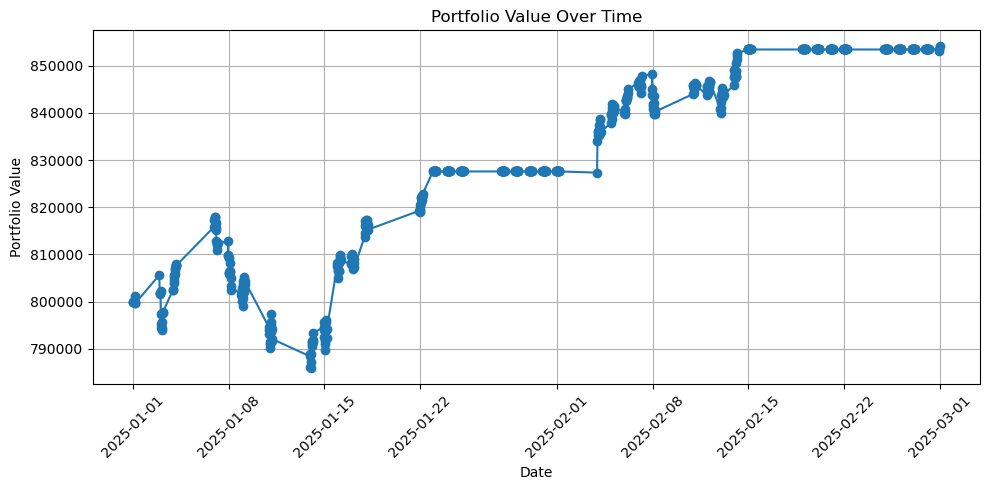

In [90]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(trading_results3['Date'], trading_results3['Portfolio_Value'], marker='o')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()

In [142]:
import pandas as pd
import numpy as np

# Initial investment and settings
initial_investment = 800000
commission_rate = 0.0003
stop_loss_pct = 0.05  # 5% stop loss
trading_results3 = merged.copy().reset_index(drop=True)
initial_spy_price = trading_results3['SPY_Actual'].iloc[0]

# Initial allocations
cash = initial_investment
position = 0  # SPY units
total_commission = 0
entry_price = None  # Track entry price for stop-loss

# Buy-and-hold benchmark
buy_and_hold_units = int(initial_investment / initial_spy_price)
buy_and_hold_final_value = buy_and_hold_units * trading_results3['SPY_Actual'].iloc[-1]
buy_and_hold_return_pct = (buy_and_hold_final_value / initial_investment - 1) * 100

# Calculate price change predictions
trading_results3['Predicted_Diff'] = trading_results3['SPY_Predicted'] / trading_results3['Open'] - 1

# Create trading signals
trading_results3['Signal'] = 0

# Initialize tracking columns
trading_results3['Position'] = 0
trading_results3['Cash'] = cash
trading_results3['Portfolio_Value'] = initial_investment
trading_results3['Trade_Action'] = 'Hold'
trading_results3['Vol_Mean'] = trading_results3['Volume_lag1'].rolling(20).mean()

for i in range(len(trading_results3)):
    current_price = trading_results3['SPY_Actual'].iloc[i]
    current_open = trading_results3['Open'].iloc[i]
    prev_ma20 = trading_results3['MA20_lag1'].iloc[i]
    prev_ma50 = trading_results3['MA50_lag1'].iloc[i]
    upperbb = trading_results3['BB_Upper_lag1'].iloc[i]
    lowerbb = trading_results3['BB_Lower_lag1'].iloc[i]
    vol_mean = trading_results3['Vol_Mean'].iloc[i]

    # Generate trading signals
    if trading_results3.at[i, 'Predicted_Diff'] > 0 and current_open <= lowerbb: 
        trading_results3.at[i, 'Signal'] = 1  # Buy signal
    elif trading_results3.at[i, 'Predicted_Diff'] < 0 and current_open >= upperbb and trading_results3['Volume_lag1'].iloc[i] > vol_mean:
        trading_results3.at[i, 'Signal'] = -1  # Sell signal

    current_signal = trading_results3['Signal'].iloc[i]

    # **Stop-loss condition**
    if position > 0 and current_price < entry_price * (1 - stop_loss_pct):
        current_signal = -1  # Force sell

    # **Trading logic - no short selling allowed**
    if current_signal == 1 and cash > current_price:  # Buy signal
        max_buy_units = int(cash / (current_price * (1 + commission_rate)))  # Adjust for commission
        if max_buy_units > 0:
            buy_units = max_buy_units
            commission = buy_units * current_price * commission_rate
            cash -= (buy_units * current_price + commission)
            total_commission += commission
            position += buy_units
            entry_price = current_price  # Record entry price for stop-loss
            trading_results3.at[i, 'Trade_Action'] = 'Buy' if position == buy_units else 'Add Long'

    elif current_signal == -1 and position > 0:  # Sell signal
        sell_amount = position * current_price
        commission = sell_amount * commission_rate
        total_commission += commission
        cash += sell_amount - commission
        position = 0  # Close position
        trading_results3.at[i, 'Trade_Action'] = 'Sell'

    # Update tracking columns
    portfolio_value = cash + position * current_price
    trading_results3.at[i, 'Position'] = position
    trading_results3.at[i, 'Cash'] = cash
    trading_results3.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate performance metrics
total_return_pct = (trading_results3['Portfolio_Value'].iloc[-1] / initial_investment - 1) * 100
num_trades = len(trading_results3[trading_results3['Trade_Action'] != 'Hold'])
max_drawdown_pct = ((trading_results3['Portfolio_Value'].cummax() - trading_results3['Portfolio_Value']) / trading_results3['Portfolio_Value'].cummax()).max() * 100

# Print final stats
print(f"Total Return: {total_return_pct:.2f}%")
print(f"Buy-and-Hold Return: {buy_and_hold_return_pct:.2f}%")
print(f"Number of Trades: {num_trades}")
print(f"Maximum Drawdown: {max_drawdown_pct:.2f}%")
print(f"Final Portfolio Value: {trading_results3['Portfolio_Value'].iloc[-1]:,.2f}")
print(f"Final Cash: {trading_results3['Cash'].iloc[-1]:,.2f}")
print(f"Final Position: {trading_results3['Position'].iloc[-1]}")
print(f"Total Commission Paid: {total_commission:,.2f}")

Total Return: 8.99%
Buy-and-Hold Return: 0.33%
Number of Trades: 9
Maximum Drawdown: 0.97%
Final Portfolio Value: 871,898.29
Final Cash: 355.89
Final Position: 1480
Total Commission Paid: 2,259.46


/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_73580/473316827.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '71.05328800005373' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Cash'] = cash
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_73580/473316827.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '799760.093288' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Portfolio_Value'] = portfolio_value


In [143]:
trading_results3

,Date,SPY_Actual,SPY_Predicted,SPY_PrevClose,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,BB_Upper_lag1,BB_Lower_lag1,BB_Width_lag1,Predicted_Diff,Signal,Position,Cash,Portfolio_Value,Trade_Action,Vol_Mean
0,2025-01-01 00:00:00,586.900,588.502670,588.730,588.78,589.56,590.06,588.570,589.223,590.010,...,596.992870,583.264630,0.023295,-0.000471,0,0,800000.000000,800000.000000,Hold,NaN
1,2025-01-01 00:30:00,587.060,586.968758,586.900,586.88,588.78,588.80,586.820,588.662,589.595,...,595.744104,583.804396,0.020256,0.000151,0,0,800000.000000,800000.000000,Hold,NaN
2,2025-01-01 01:00:00,585.860,587.495580,587.060,587.04,586.88,587.84,586.540,588.422,589.242,...,595.071161,583.658339,0.019362,0.000776,0,0,800000.000000,800000.000000,Hold,NaN
3,2025-01-01 01:30:00,587.205,585.988060,585.860,585.86,587.04,587.40,585.740,587.632,588.716,...,594.867382,583.096118,0.019975,0.000219,0,0,800000.000000,800000.000000,Hold,NaN
4,2025-01-01 02:00:00,584.960,586.748484,587.205,587.12,585.86,587.31,584.900,587.151,588.405,...,594.440660,582.742340,0.019856,-0.000633,0,0,800000.000000,800000.000000,Hold,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2025-02-28 04:00:00,586.680,588.014102,589.185,589.18,590.73,590.78,588.340,592.339,593.115,...,598.556283,589.045317,0.016034,-0.001979,0,0,866608.085159,866608.085159,Hold,2247433.60
503,2025-02-28 04:30:00,585.130,587.134674,586.680,586.62,589.18,589.35,586.240,590.991,592.242,...,598.783167,587.679333,0.018734,0.000877,1,1480,355.887439,866348.287439,Buy,2437814.80
504,2025-02-28 22:30:00,585.835,586.081226,585.130,585.56,586.62,587.57,584.650,589.099,591.414,...,599.037859,586.072641,0.021893,0.000890,1,1480,355.887439,867391.687439,Hold,2960406.25
505,2025-02-28 23:00:00,588.250,586.202982,585.835,585.85,585.56,586.33,583.270,587.508,590.581,...,599.201838,584.941162,0.024101,0.000603,0,1480,355.887439,870965.887439,Hold,3187313.25


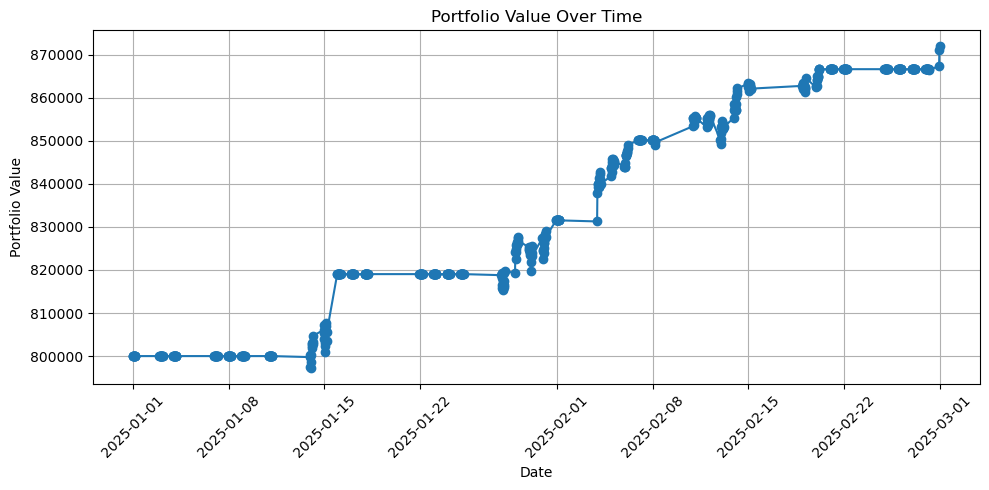

In [144]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(trading_results3['Date'], trading_results3['Portfolio_Value'], marker='o')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()

In [1132]:
# Increased risk parameters
initial_cash_percent = 0.5  # Only 5% cash reserve (was 10%)

# Aggressive signal thresholds (wider than original)
buy_threshold = 0.0003  # 0.05% predicted gain
sell_threshold = -0.0007 # 0.07% predicted drop

# assume initial investmennt of $100,000, buy on 1 jan
initial_investment = 100000
commission_rate = 0.0005
trading_results3 = merged.copy().reset_index(drop=True)
initial_spy_price = trading_results3['SPY_Actual'].iloc[0]

# Modify initial allocation
cash = initial_investment * initial_cash_percent
spy_units = (initial_investment - cash) / initial_spy_price

# Calculate price change predictions
# trading_results['Predicted_Change'] = trading_results['Predicted'].pct_change()
trading_results3['Predicted_Diff'] = trading_results3['SPY_Predicted']/trading_results3['Open'] - 1
   
# Create trading signals (1 = buy/hold BTC, 0 = hold cash)
trading_results3['Signal'] = 0
trading_results3.loc[
    (trading_results3['Predicted_Diff'] > buy_threshold) &
    (trading_results3['MFI_lag1'] <= 24), 'Signal'] = 1

# Sell only if volume is above average
trading_results3.loc[
    (trading_results3['Predicted_Diff'] < sell_threshold) &
    (trading_results3['MFI_lag1'] >= 76), 'Signal'] = -1

# Initialize parameters
position = 0  # Current position (can be any integer, positive for long, negative for short)
cumulative_pnl = 0
entry_price = 0

# Initialize tracking columns
trading_results3['Position'] = 0
trading_results3['PnL'] = 0
trading_results3['Cumulative_PnL'] = 0
trading_results3['Trade_Action'] = 'Hold'

for i in range(len(trading_results3)):
    current_price = trading_results3['SPY_Actual'].iloc[i]
    current_signal = trading_results3['Signal'].iloc[i]
    
    # Calculate daily PnL for the current position
    if position != 0 and i > 0:
        price_change = current_price - trading_results3['SPY_Actual'].iloc[i-1]
        daily_pnl = position * price_change
        cumulative_pnl += daily_pnl
        trading_results3.at[i, 'PnL'] = daily_pnl
    
    # Trading logic: Handle signals and positions
    if current_signal != 0:
        if np.sign(current_signal) == np.sign(position):  # Same direction as current position
            # Accumulate position
            trading_results3.at[i, 'Trade_Action'] = 'Add Long' if current_signal > 0 else 'Add Short'
            position += current_signal
        else:
            # Close existing position if opposite signal
            if position != 0:
                exit_pnl = position * (current_price - entry_price)
                cumulative_pnl += exit_pnl
                trading_results3.at[i, 'PnL'] += exit_pnl  # Add realized PnL for closing
                trading_results3.at[i, 'Trade_Action'] = 'Close & Reverse' if current_signal != 0 else 'Close Position'
            
            # Open new position in the opposite direction or neutralize
            entry_price = current_price
            position = current_signal
    
    # Update tracking columns
    trading_results3.at[i, 'Position'] = position
    trading_results3.at[i, 'Cumulative_PnL'] = cumulative_pnl

# Calculate performance metrics
num_trades = len(trading_results3[trading_results3['Trade_Action'] != 'Hold'])

print(f"Final Cumulative PnL: ${cumulative_pnl:.2f}")
print(f"Number of Trades: {num_trades}")
print(f"Average Return per Trade: ${cumulative_pnl/num_trades:.2f}" if num_trades > 0 else "No trades")

Final Cumulative PnL: $1180.71
Number of Trades: 39
Average Return per Trade: $30.27


/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/2878780519.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1200000000000045' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'PnL'] = daily_pnl
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/2878780519.py:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1200000000000045' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Cumulative_PnL'] = cumulative_pnl


In [1136]:
max(trading_results3['Position'])

6

In [1135]:
min(trading_results3['Position'])

-16

In [1116]:
# Increased risk parameters
initial_cash_percent = 0.5  # Only 5% cash reserve (was 10%)

# Aggressive signal thresholds (wider than original)
buy_threshold = 0.0003  # 0.05% predicted gain
sell_threshold = -0.0007 # 0.07% predicted drop

# assume initial investmennt of $100,000, buy on 1 jan
initial_investment = 100000
commission_rate = 0.0005
trading_results3 = merged.copy().reset_index(drop=True)
initial_spy_price = trading_results3['SPY_Actual'].iloc[0]

# Modify initial allocation
cash = initial_investment * initial_cash_percent
spy_units = (initial_investment - cash) / initial_spy_price

# Calculate price change predictions
# trading_results['Predicted_Change'] = trading_results['Predicted'].pct_change()
trading_results3['Predicted_Diff'] = trading_results3['SPY_Predicted']/trading_results3['Open'] - 1
   
# Create trading signals (1 = buy/hold BTC, 0 = hold cash)
trading_results3['Signal'] = 0
trading_results3.loc[
    (trading_results3['Predicted_Diff'] > buy_threshold) &
    (trading_results3['MFI_lag1'] <= 24), 'Signal'] = 1

# Sell only if volume is above average
trading_results3.loc[
    (trading_results3['Predicted_Diff'] < sell_threshold) &
    (trading_results3['MFI_lag1'] >= 76), 'Signal'] = -1

# Track position changes
trading_results3['Position_Change'] = trading_results3['Signal'].diff().abs()

# Add new column for Trade_Action
trading_results3['Trade_Action'] = 'Hold'

# Initialize parameters
initial_price = trading_results3['SPY_Actual'].iloc[0]
position = 0  # Can be -1, 0, or 1

# Initialize parameters
initial_price = trading_results3['SPY_Actual'].iloc[0]
position = 0  # Can be -1, 0, or 1
cumulative_pnl = 0  # Initialize cumulative PnL

# Initialize tracking columns
trading_results3['Position'] = 0
trading_results3['PnL'] = 0
trading_results3['Cumulative_PnL'] = 0
trading_results3['Trade_Action'] = 'Hold'

for i in range(len(trading_results3)):
    current_price = trading_results3['SPY_Actual'].iloc[i]
    current_signal = trading_results3['Signal'].iloc[i]
    
    # Calculate PnL for the current position
    if i > 0:
        price_change = current_price - trading_results3['SPY_Actual'].iloc[i-1]
        pnl = position * price_change
        cumulative_pnl += pnl
        trading_results3.at[i, 'PnL'] = pnl
        trading_results3.at[i, 'Cumulative_PnL'] = cumulative_pnl
    
    # Only trade if signal changes
    if current_signal != position:
        if current_signal == 1 and position <= 0:
            # Buy or cover short
            trading_results3.at[i, 'Trade_Action'] = 'Buy 1' if position == 0 else 'Cover & Buy 1'
            position += 1
        elif current_signal == -1 and position >= 0:
            # Sell or short
            trading_results3.at[i, 'Trade_Action'] = 'Sell 1' if position == 0 else 'Sell & Short 1'
            position -= 1
    
    # Update position
    trading_results3.at[i, 'Position'] = position

# Calculate returns
initial_investment = 100000  # Assuming a notional investment for return calculation
trading_results3['Returns'] = trading_results3['Cumulative_PnL'] / initial_investment
cumulative_return = (trading_results3['Cumulative_PnL'].iloc[-1] / initial_investment) * 100

print(f"Final PnL: ${trading_results3['Cumulative_PnL'].iloc[-1]:.2f}")
print(f"Cumulative Return: {cumulative_return:.2f}%")
print(f"Number of Trades: {len(trading_results3[trading_results3['Trade_Action'] != 'Hold'])}")

# Additional performance metrics
sharpe_ratio = np.sqrt(252) * trading_results3['Returns'].mean() / trading_results3['Returns'].std()
max_drawdown = (trading_results3['Cumulative_PnL'].cummax() - trading_results3['Cumulative_PnL']).max() / initial_investment * 100

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")

Final PnL: $41.94
Cumulative Return: 0.04%
Number of Trades: 7
Sharpe Ratio: 23.20
Maximum Drawdown: 0.02%


/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/1986075704.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1200000000000045' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'PnL'] = pnl
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/1986075704.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1200000000000045' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Cumulative_PnL'] = cumulative_pnl


In [ ]:
# Increased risk parameters
initial_cash_percent = 0.5  # Only 5% cash reserve (was 10%)

# Aggressive signal thresholds (wider than original)
buy_threshold = 0.0003  # 0.05% predicted gain
sell_threshold = -0.0008 # 0.07% predicted drop

# assume initial investmennt of $100,000, buy on 1 jan
initial_investment = 100000
commission_rate = 0.0005
trading_results3 = merged.copy().reset_index(drop=True)
initial_spy_price = trading_results3['SPY_Actual'].iloc[0]

# Modify initial allocation
cash = initial_investment * initial_cash_percent
spy_units = (initial_investment - cash) / initial_spy_price

# Calculate price change predictions
# trading_results['Predicted_Change'] = trading_results['Predicted'].pct_change()
trading_results3['Predicted_Diff'] = trading_results3['SPY_Predicted']/trading_results3['Open'] - 1
   
# Create trading signals (1 = buy/hold BTC, 0 = hold cash)
trading_results3['Signal'] = 0
trading_results3.loc[
    (trading_results3['Predicted_Diff'] > buy_threshold) &
    (trading_results3['%D_lag1'] <= trading_results3['%K_lag1']), 'Signal'] = 1

# Sell only if volume is above average
trading_results3.loc[
    (trading_results3['Predicted_Diff'] < sell_threshold) &
    (trading_results3['Volume_lag1'] > trading_results3['Volume_lag1'].rolling(20).mean()), 'Signal'] = -1

# Initialize portfolio value columns
trading_results3['SPY_Units'] = 0
trading_results3['Cash'] = 0
trading_results3['Portfolio_Value'] = 0

# Track position changes
trading_results3['Position_Change'] = trading_results3['Signal'].diff().abs()

# Add new column for Trade_Action
trading_results3['Trade_Action'] = 'Hold'

# Dynamic position sizing function
def calculate_trade_size(portfolio_value, current_price, bb_upper, bb_lower, is_buy_signal):
    base_risk_percentage = 0.04 # 4% of portfolio
    bb_position = (current_price - bb_lower) / (bb_upper - bb_lower)
    
    if is_buy_signal:
        # Increase risk for buy signals
        base_risk_percentage *= 1.2  # 20% increase in risk for buys
    
    if bb_position < 0.2:
        risk_multiplier = 1.5
    elif bb_position > 0.8:
        risk_multiplier = 0.5
    else:
        risk_multiplier = 1.0
    
    risk_amount = portfolio_value * base_risk_percentage * risk_multiplier
    raw_size = risk_amount / current_price
    
    max_units = int(portfolio_value * 0.07 / current_price)  # Increased from 5% to 7%
    final_size = min(int(raw_size), max_units)
    return final_size

buy_trades = 0
sell_trades = 0

# Modified trading loop
for i in range(len(trading_results3)):
    current_price = trading_results3['SPY_Actual'].iloc[i]
    current_signal = trading_results3['Signal'].iloc[i]
    predicted_diff = trading_results3['Predicted_Diff'].iloc[i]
    bb_upper = trading_results3['BB_Upper_lag1'].iloc[i]
    bb_lower = trading_results3['BB_Lower_lag1'].iloc[i]
    
    portfolio_value = spy_units * current_price + cash
    is_buy_signal = (current_signal == 1)
    trade_size = calculate_trade_size(portfolio_value, current_price, bb_upper, bb_lower, is_buy_signal)
    trade_action = 'Hold'

    if current_signal == 1:  # Buy
        required = trade_size * current_price * (1 + commission_rate)
        if cash >= required:
            spy_units += trade_size
            cash -= required
            trade_action = f'Buy {trade_size} units'
            buy_trades += 1
    elif current_signal == -1:  # Sell
        if spy_units >= trade_size:
            proceeds = trade_size * current_price * (1 - commission_rate)
            spy_units -= trade_size
            cash += proceeds
            trade_action = f'Sell {trade_size} units'
            sell_trades += 1

    # Update values
    trading_results3.at[i, 'SPY_Units'] = spy_units
    trading_results3.at[i, 'Cash'] = cash
    trading_results3.at[i, 'Portfolio_Value'] = spy_units * current_price + cash
    trading_results3.at[i, 'Trade_Action'] = trade_action
    trading_results3.at[i, 'Accurate'] = trading_results3.at[i, 'Predicted_Diff'] * (trading_results3.at[i, 'SPY_Actual'] - trading_results3.at[i, 'Open']) >= 0

/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/2010333394.py:99: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '85.19338899301414' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'SPY_Units'] = spy_units
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/2010333394.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100013.63094223887' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trading_results3.at[i, 'Portfolio_Value'] = spy_units * current_price + cash
/var/folders/m1/8hpzpvj13gv31qbqb9jz7v7c0000gn/T/ipykernel_14729/2010333394.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '45308.61548' has dty

In [640]:
trading_results3

,Date,SPY_Actual,SPY_Predicted,SPY_PrevClose,Open,Open_lag1,High_lag1,Low_lag1,SMAVG (5) on Close_lag1,SMAVG (10) on Close_lag1,...,Strategy_Cumulative,BuyHold_Cumulative,Predicted_Diff,Signal,SPY_Units,Cash,Portfolio_Value,Position_Change,Trade_Action,Accurate
0,2025-01-01 00:00:00,586.900,588.502670,588.730,588.78,589.56,590.06,588.570,589.223,590.010,...,NaN,NaN,-0.000471,0,85.193389,50000.000000,100000.000000,NaN,Hold,True
1,2025-01-01 00:30:00,587.060,586.968758,586.900,586.88,588.78,588.80,586.820,588.662,589.595,...,1.000000,1.000273,0.000151,0,85.193389,50000.000000,100013.630942,0.0,Hold,True
2,2025-01-01 01:00:00,585.860,587.495580,587.060,587.04,586.88,587.84,586.540,588.422,589.242,...,1.000000,0.998228,0.000776,0,85.193389,50000.000000,99911.398875,0.0,Hold,False
3,2025-01-01 01:30:00,587.205,585.988060,585.860,585.86,587.04,587.40,585.740,587.632,588.716,...,1.000000,1.000520,0.000219,0,85.193389,50000.000000,100025.983984,0.0,Hold,True
4,2025-01-01 02:00:00,584.960,586.748484,587.205,587.12,585.86,587.31,584.900,587.151,588.405,...,1.000000,0.996694,-0.000633,0,85.193389,50000.000000,99834.724825,0.0,Hold,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2025-02-28 04:00:00,586.680,588.014102,589.185,589.18,590.73,590.78,588.340,592.339,593.115,...,1.026641,0.999625,-0.001979,-1,2.193389,101796.379099,103083.196553,1.0,Sell 10 units,True
503,2025-02-28 04:30:00,585.130,587.134674,586.680,586.62,589.18,589.35,586.240,590.991,592.242,...,1.026641,0.996984,0.000877,0,2.193389,101796.379099,103079.796800,1.0,Hold,False
504,2025-02-28 22:30:00,585.835,586.081226,585.130,585.56,586.62,587.57,584.650,589.099,591.414,...,1.026641,0.998185,0.000890,0,2.193389,101796.379099,103081.343139,0.0,Hold,True
505,2025-02-28 23:00:00,588.250,586.202982,585.835,585.85,585.56,586.33,583.270,587.508,590.581,...,1.026641,1.002300,0.000603,1,10.193389,97088.026099,103084.287174,1.0,Buy 8 units,True


In [641]:
len(trading_results3[trading_results3['Accurate'] == True])

242

In [628]:
len(trading_results3[trading_results3['Predicted_Diff'] > buy_threshold])

100

In [629]:
print(buy_trades)
print(sell_trades)

33
36
